In [1]:
import numpy as np
import torch
import umap
from utils import get_coords, plot_diagrams
from gudhi.clustering.tomato import Tomato
from collections import Counter
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.spatial.distance import pdist, squareform

In [2]:
neurons = torch.load("activations/ILSVRC2015/inception4a.pt").detach().numpy().T
print(neurons.shape)

(512, 50761)


In [3]:
layout_2d = umap.UMAP(
    n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(neurons)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Fri Feb 11 11:14:06 2022 Construct fuzzy simplicial set
Fri Feb 11 11:14:12 2022 Finding Nearest Neighbors
Fri Feb 11 11:14:13 2022 Finished Nearest Neighbor Search
Fri Feb 11 11:14:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Feb 11 11:14:15 2022 Finished embedding


/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/point_cloud/dtm.py:164: RuntimeWarning: overflow encountered in power
  distances = distances ** q
/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/clustering/tomato.py:174: RuntimeWarning: divide by zero encountered in log
  weights = numpy.log(weights)
/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/clustering/tomato.py:286: RuntimeWarning: invalid value encountered in double_scalars
  self.max_weight_per_cc_, numpy.full(self.max_weight_per_cc_.shape, 1.1 * l - 0.1 * r), "o", color="green"


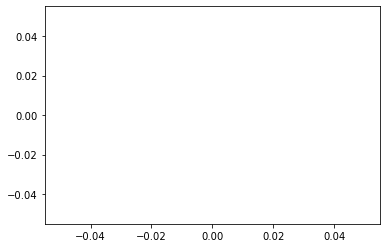

7
[(4, 438), (0, 23), (3, 20), (2, 12), (1, 11), (6, 5), (5, 3)]


In [8]:
t = Tomato(density_type="logDTM", k=100)
clusters = t.fit_predict(neurons)
t.plot_diagram()
print(t.n_clusters_)
print(Counter(t.labels_).most_common(10))

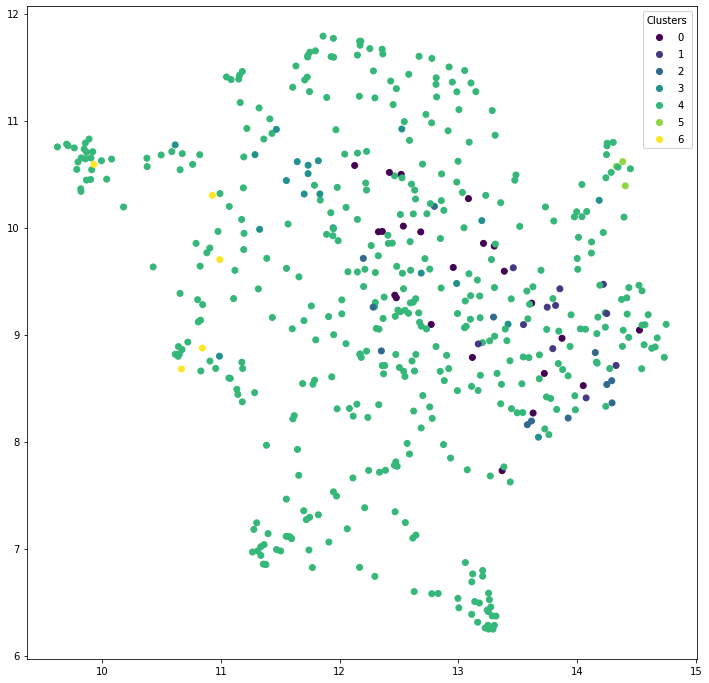

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1], c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

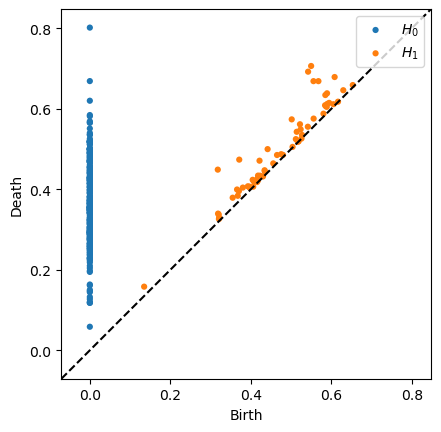

In [9]:
maxdim = 1
coeff = 47
metric = "cosine"  # cosine, euclidean
distance_matrix = squareform(pdist(neurons, metric))
persistence = ripser(
    distance_matrix,
    maxdim=maxdim,
    coeff=coeff,
    do_cocycles=True,
    distance_matrix=True,
)
fig, ax = plt.subplots()
plot_diagrams(persistence["dgms"], plot_only=np.arange(maxdim + 1), ax=ax, show=True)

In [10]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

f, verts = get_coords(cocycle, threshold, len(neurons), distance_matrix, 47)

print(len(f))

256
